# General libraries

In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import QED

#For debugging, reimport modules when executing cells
%load_ext autoreload
%autoreload 2

molvecgen_path = Path("/home/rafalb/work/molecules/molvecgen/molvecgen")
sys.path.append(molvecgen_path.absolute().as_posix())

from vectorizers import SmilesVectorizer
from generators import HetSmilesGenerator, SmilesSequence, SmilesGenerator, CodeGenerator, SmilesGenerator2

In [ ]:
smiles = [ "CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2",
            "CCC[S@@](=O)c1ccc2c(c1)[nH]/c(=N/C(=O)OC)/[nH]2"]*10
          
mols =   [Chem.MolFromSmiles(smile) for smile in smiles]

In [ ]:
sm_en = SmilesVectorizer(canonical=True, augment=False)

print("Default Charset %s"%sm_en.charset)
print("Default Maximum allowed SMILES length %s"%sm_en.maxlength)

sm_en.fit(mols, extra_chars=["\\"])
print()
print("After fitting")
print("Charset after fit %s"%sm_en.charset)
print("Length of charset %s"%len(sm_en.charset))
print("Maximum allowed SMILES length %s"%sm_en.maxlength)

In [ ]:
mol_vects = sm_en.transform(mols)
plt.matshow(mol_vects[0].T)

In [ ]:
mol_vects.shape

In [ ]:
#We make up some labels
y = range(len(mols))
smi_seq = SmilesSequence(mols, y, sm_en, batch_size=3)
print(len(smi_seq))

In [ ]:
batch_x, batch_y = smi_seq[0]
print(batch_y)

In [ ]:
y=[1,2]*10
#Set data augmentation on
sm_en.augment=True
sm_en.canonical=False

sm_gn = SmilesGenerator(mols, y, sm_en, batch_size=4, shuffle=True)

batch_x, batch_y = sm_gn.next()
print(batch_x.shape)
print(batch_y.shape)

In [ ]:
#If settings on generator is the same, it can be reused, otherwise recreate
import copy
vect1 = sm_en
vect2 = copy.deepcopy(sm_en)
vect2.augment = False # Set the augment to be false for testing purposes
vect2.leftpad = False # Set the order of the SMILES to be from left to right

print(vect1.augment)
print(vect2.augment) 

In [ ]:
batchgen = HetSmilesGenerator(mols, None, vect1, vect2, batch_size=3) #Y is None
_input, _output = batchgen.next()

In [ ]:
plt.matshow(_input[0][0].T)
plt.matshow(_input[1][0].T)
plt.matshow(_output[0].T)

In [ ]:
zinc20_path = Path("/storage2/zinc20")

In [ ]:
def read_smiles_file(smiles_file, delimiter=' ', smiles_column=0,
                     name_column=1, header=False, requires_length=False):
    """Read a SMILES file.

    Parameters
    ----------
    smiles_file: path to a SMILES file
    requires_length: If True returns an enumerated Mol
        supplier, i.e. when monitoring progress

    Returns
    -------
    either a MolSupplier or an EnumeratedSupplier
    depending on whether a length is required
    """

    if requires_length is False:
        return MolSupplier(
            SmilesMolSupplier(
                smiles_file,
                delimiter,
                smiles_column,
                name_column,
                header,
                True))

    count = smiles_count(smiles_file)
    if header is True:
        count -= 1

    supplier = SmilesMolSupplier(smiles_file, delimiter, smiles_column, name_column, header, True)

    return EnumeratedMolSupplier(supplier, count) 

In [ ]:
def read_smiles(path):
    result = []
    suppl = Chem.SmilesMolSupplier(path)
    for mol in suppl: result.append(mol)
    return result 

In [ ]:
zinc_file = "AA/AAAD.smi"
path = (zinc20_path/zinc_file).absolute().as_posix()
mols = read_smiles(path)

smiles = [Chem.MolToSmiles(mol) for mol in mols]
smiles_lens = [len(smi) for smi in smiles]
smiles_df = pd.DataFrame({"smiles": smiles, "lengths": smiles_lens})

In [ ]:
smiles_df["lengths"].hist()

In [ ]:
sm_en = SmilesVectorizer(canonical=True, augment=False)

print("Default Charset %s"%sm_en.charset)
print("Default Maximum allowed SMILES length %s"%sm_en.maxlength)

sm_en.fit(mols, extra_chars=["\\"])
print()
print("After fitting")
print("Charset after fit %s"%sm_en.charset)
print("Length of charset %s"%len(sm_en.charset))
print("Maximum allowed SMILES length %s"%sm_en.maxlength)

In [ ]:
vect1 = sm_en
vect2 = copy.deepcopy(sm_en)
vect2.augment = False # Set the augment to be false for testing purposes
vect2.leftpad = False # Set the order of the SMILES to be from left to right

print(vect1.augment)
print(vect2.augment) 

In [ ]:
batchgen = HetSmilesGenerator(mols, None, vect1, vect2, batch_size=3) #Y is None
_input, _output = batchgen.next()

In [ ]:
plt.matshow(_input[0][0].T)
plt.matshow(_input[1][0].T)
plt.matshow(_output[0].T)

In [ ]:
data_path = Path("/home/rafalb/work/molecules/moleculeAE/moleculeae/data/processed")
qedDF = pd.read_csv((data_path/"qed_1000000_reference.csv"), index_col=0)
qedDF

In [ ]:
smilesCodes = qedDF['smiles']
descs = qedDF[['ALOGP', 'AROM', 'HBA', 'HBD', 'PSA', 'ROTB', 'MW']].values
descs = descs.astype(float)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
descs = ss.fit_transform(descs)

from sklearn.decomposition import PCA
pca = PCA(n_components=descs.shape[1])
descs = pca.fit_transform(descs)

mols = [Chem.MolFromSmiles(smiles) for smiles in smilesCodes]
mols_bin = [Chem.rdchem.Mol.ToBinary(Chem.MolFromSmiles(smiles)) for smiles in smilesCodes]

In [ ]:
vectmp = SmilesVectorizer(canonical=False, augment=True, binary=True)
vectmp.fit(mols)
maxlength = vectmp.maxlength
charset = vectmp.charset

In [ ]:
smilesvec1 = SmilesVectorizer(canonical=False, augment=True, binary=True, maxlength=maxlength, 
                              charset=charset, pad=30)
smilesvec2 = SmilesVectorizer(canonical=False, augment=True, binary=True, leftpad=False, maxlength=maxlength, 
                              charset=charset, pad=30)

In [ ]:
batch_size = 256
trainCutOff = 180000
x_train = descs[:trainCutOff]
x_valid = descs[trainCutOff:]
y_train = mols_bin[:trainCutOff]
y_valid = mols_bin[trainCutOff:]


steps_per_epoch = trainCutOff // batch_size
steps_per_validataion = (len(mols) - trainCutOff) // batch_size
cg_train = CodeGenerator(x_train, y_train, smilesvec1, smilesvec2, 
                         batch_size=batch_size, shuffle=True)
cg_val = CodeGenerator(x_valid, y_valid, smilesvec1, smilesvec2, 
                       batch_size=batch_size, shuffle=True)

# Conditional recurrent

## Libraries

In [ ]:
from tensorflow.compat.v1.keras.layers import (
    CuDNNLSTM as LSTM,
)
from tensorflow.keras.layers import TimeDistributed, concatenate, Input, Dense, RepeatVector, \
Lambda,  Convolution1D, Flatten, GRU, BatchNormalization, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import initializers

from tensorflow_addons.layers import WeightNormalization

import tensorflow.keras.backend as K
import tensorflow as tf

In [ ]:
tf.__version__

In [ ]:
def getFClatent(stateArch, inputLayer, label, batchNorm=True, dropoutRatio=0.3, activation='elu'):
    x = inputLayer
    for idx, iLayerDim in enumerate(stateArch):
        x = Dense(iLayerDim, activation=activation, name=label+'_Dense_'+str(idx))(x)
        if batchNorm[0]: x = BatchNormalization(momentum=batchNorm[1], name=label+'_Dense_BN_'+str(idx))(x)
        if dropoutRatio > 0:
            x = Dropout(dropoutRatio, name=label+'_Dense_DR_'+str(idx))(x)
        
    return x

In [ ]:
stateArch = [32, 32]
inputDim = cg_train.input_dims
batchNorm = (True, 0.9)
inputLayer = Input(shape=(inputDim), name = 'molecularDescriptorInput')

x = getFClatent(stateArch, inputLayer, 'state1', batchNorm=batchNorm, dropoutRatio=0.3, activation='relu')

In [ ]:
def getInitialStates(inputDim, nRecurrentUnits, nStatesEntities, stateLabels, FCArch, 
                     batchNorm=True, dropoutRatio=0.35, activation='elu'):
    
    whereAmI = 'StaticToStates'
    
    architecturalComponent = '_StaticInput_'
    label = whereAmI+architecturalComponent
    decoderStates = []
    staticInput = Input(shape=(inputDim), name=label)
    
    architecturalComponent = '_StaticFCtransformation_'
    for iLayer in range(nRecurrentUnits):
        for iState, iStateLabel in zip(range(nStatesEntities), statesLabels):
            label = whereAmI+architecturalComponent+'_'+str(iLayer)+'_'+str(iState)
            stateX = getFClatent(FCArch, staticInput, label, batchNorm=batchNorm, 
                                 dropoutRatio=dropoutRatio, activation=activation)
            decoderStates.append(stateX)
    
    model = Model(staticInput, decoderStates)
    model._name = 'StaticToStatesModel'
    return staticInput, model

In [ ]:
inputDim = cg_train.input_dims
nRecurrentUnits = 3
nStatesEntities = 2
statesLabels = ['h', 'c']
FCArch = [256]
dropoutRatio = 0.0
activation = 'relu'
batchNorm = (True, 0.9)
staticInput, recStates = getInitialStates(inputDim, nRecurrentUnits, nStatesEntities, statesLabels, FCArch, 
                             batchNorm=batchNorm, dropoutRatio=dropoutRatio, activation=activation)

In [ ]:
plot_model(recStates)

In [ ]:
recStates.summary()

In [ ]:
def getConditionedRecurrentUnits(seqTensorDim, DecoderRecurrentLayers, nStatesEntities, nStateInputDim, statesLabels,
                                 doBN, doSqueeze, nOutputDim):
    '''
    This
    '''
    whereAmI = 'DecoderCond'
    
    allInputs = []
    
    architecturalComponent = '_DynamicInput_'
    label = whereAmI+architecturalComponent
    sequentialInput = Input(shape=seqTensorDim, name=label)
    allInputs.append(sequentialInput)
        
    # create an input dictionary with initial states of recurrent units
    statesInputs = {}
    architecturalComponent = '_StaticInput_'
    for iLayer, recDim in enumerate(DecoderRecurrentLayers):
        for iState, iStateLabel in zip(range(nStatesEntities), statesLabels):
            label = whereAmI+architecturalComponent+iStateLabel+'_'+str(iLayer)
            print(label)
            stateX = Input(shape=[nStateInputDim], name=label)
            allInputs.append(stateX)
            key = iStateLabel+'_'+str(iLayer)
            statesInputs[key] = stateX
    
    x = sequentialInput
    for iLayer, recDim in enumerate(DecoderRecurrentLayers):
        print(iLayer, recDim)
        states = []
        for iState, iStateLabel in zip(range(nStatesEntities), statesLabels):
            key = iStateLabel+'_'+str(iLayer)
            states.append(statesInputs[key])


        architecturalComponent = '_InternalRecurrent_'
        label = whereAmI+architecturalComponent+str(iLayer)
        decoderRNN = LSTM(recDim, return_sequences=True, name=label)
        x = decoderRNN(x, initial_state=states)

        if doBN[0]:
            architecturalComponent = '_InternalRecurrent_BN_'
            label = whereAmI+architecturalComponent+str(iLayer)+'_'+str(iLayer)
            x = BatchNormalization(momentum=doBN[1], name=label)(x)

    if doSqueeze[0]:
        architecturalComponent = '_InternalRecurrent_Squeeze_'
        label = whereAmI+architecturalComponent+str(iLayer)
        x = TimeDistributed(Dense(doSqueeze[1]), name=label)(x)
    
    architecturalComponent = '_FinalLayer_'
    label = whereAmI+architecturalComponent
    outputLayer = Dense(nOutputDim, activation='softmax', name=label)(x)
    
    model = Model(inputs=allInputs, outputs=[outputLayer])
    model._name = 'conditionedRecurrent'
    #return allInputs, outputLayer
    return sequentialInput, model

In [ ]:
seqTensorDim = cg_train.dec_dims
nDecoderInputLayers = 1
DecoderRecurrentLayers = [FCArch[-1], FCArch[-1], FCArch[-1]]
nStatesEntities = 2
nStateInputDim = FCArch[-1]
statesLabels = ['h', 'c']
nOutputDim = cg_train.dec_dims[-1]
doBN = (True, 0.9)
doSqueeze = (False, 32)

#dropoutRatio = 0.35
#activation = 'elu'
sequentialInput, conditionRecurrent = getConditionedRecurrentUnits(seqTensorDim, DecoderRecurrentLayers, 
                                                  nStatesEntities, nStateInputDim, statesLabels, doBN, doSqueeze, nOutputDim)

In [ ]:
plot_model(conditionRecurrent)

In [ ]:
conditionRecurrent.summary()

In [ ]:
conditionRecurrent.input

In [ ]:
completeOutput = conditionRecurrent([sequentialInput]+recStates.output)
finalModel = Model(inputs=[staticInput, sequentialInput], outputs=[completeOutput])

In [ ]:
finalModel.input

In [ ]:
plot_model(finalModel, expand_nested=True, show_layer_names=True, show_shapes=True, to_file='finalModel.png')

In [ ]:
finalModel.summary()

In [ ]:
lr = 0.001
opt = Adam(lr=lr)
loss="categorical_crossentropy"

In [ ]:
finalModel.compile(optimizer=opt, loss=loss)

In [ ]:
class LearningRateSchedule:
    """
    Class for custom learning rate schedules.
    """

    def __init__(self, epoch_to_start=500, last_epoch=999, lr_init=1e-3, lr_final=1e-6):
        self.epoch_to_start = epoch_to_start
        self.last_epoch = last_epoch
        self.lr_init = lr_init
        self.lr_final = lr_final

    def exp_decay(self, epoch, lr):
        """
        Exponential decay.
        """

        decay_duration = self.last_epoch - self.epoch_to_start
        if epoch < self.epoch_to_start:
            return lr
        else:
            # Slope of the decay
            k = -(1 / decay_duration) * np.log(self.lr_final / self.lr_init)

            lr = self.lr_init * np.exp(-k * (epoch - self.epoch_to_start))
            return lr

In [ ]:
lr_schedule = LearningRateSchedule(
    epoch_to_start=5,
    last_epoch=15,
    lr_init=0.001,
    lr_final=0.0001,
)

lr_scheduler = LearningRateScheduler(
    schedule=lr_schedule.exp_decay, verbose=1
)

callbacks = [lr_scheduler]

In [ ]:
rlr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1,
    min_delta=1e-4,
)
callbacks = [rlr]

In [ ]:
finalModel.fit(cg_train, epochs=25, validation_data=cg_val, 
                        steps_per_epoch=steps_per_epoch, validation_steps=steps_per_validataion, callbacks=callbacks,
                        max_queue_size=10)

In [ ]:
def getRecurrentLayerNames(model):
    config = model.get_config()
    names = []
    for layer in config['layers']:
        if 'LSTM' in layer['class_name'] or layer['class_name'] == 'GRU':
            names.append(layer['name'])
    return names

def prepareSampleModel(conditionRecurrent):
    conditionRecurrentConfig = conditionRecurrent.get_config()
    conditionRecurrentConfig['layers'][0]['config']['batch_input_shape'] = (1, 1, cg_train.dec_dims[-1])
    removeIdx = []
    for idx, layer in enumerate(conditionRecurrentConfig['layers']):
        if 'DecoderCond_StaticInput_' in layer['name']:
            print(layer['name'])
            
            removeIdx.append(idx)
    for idx in sorted(removeIdx, reverse=True):
        conditionRecurrentConfig["layers"].pop(idx)
        
    # Remove inbound_nodes dependencies of remaining layers on deleted ones
    for layer in conditionRecurrentConfig["layers"]:
        idx_list = []

        try:
            for idx, inbound_node in enumerate(layer["inbound_nodes"][0]):
                if 'DecoderCond_StaticInput_' in inbound_node[0]:
                    print(layer['name'])
                    idx_list.append(idx)
        # Catch the exception for first layer (Decoder_Inputs) that has empty list of inbound_nodes[0]
        except:
            pass
        print(idx_list)
        # Pop the inbound_nodes from the list
        # Revert indices to avoid re-arranging
        for idx in sorted(idx_list, reverse=True):
            layer["inbound_nodes"][0].pop(idx)
    recurrentLayers = getRecurrentLayerNames(conditionRecurrent)
    
    for idx, layer in enumerate(conditionRecurrentConfig['layers']):
        if layer['name'] in recurrentLayers:
            print(layer['name'])
            conditionRecurrentConfig['layers'][idx]['config']['stateful'] = True
            
    conditionRecurrentConfig["input_layers"] = [conditionRecurrentConfig["input_layers"][0]]
    sampleModel = Model.from_config(conditionRecurrentConfig)
    
    for layer in sampleModel.layers:
        # Get weights from the batch_model
        weights = conditionRecurrent.get_layer(layer.name).get_weights()
        # Set the weights to the sample_model
        sampleModel.get_layer(layer.name).set_weights(weights)
        
    return sampleModel

In [ ]:
sampleModel = prepareSampleModel(conditionRecurrent)

In [ ]:
def conditionRNNstates(model, DecoderRecurrentLayers, states):
    for iLayer, _ in enumerate(DecoderRecurrentLayers):
        layerName = "DecoderCond_InternalRecurrent_"+str(iLayer)
        print(layerName)
        model.get_layer(layerName).reset_states(states=[states[2*iLayer], states[2*iLayer+1]])
        #model.get_layer(layerName).reset_states()
    return model

def calculateNextCharLogits(model, currentChar, char_to_int):
    samplevec = np.zeros((1, 1, cg_train.dec_dims[-1]))
    charidx = char_to_int[currentChar]
    samplevec[0, 0, charidx] = 1
    predictedCarLogits = model.predict([samplevec])
    return predictedCarLogits

def calculateQED(smiles):
    props = QED.properties(Chem.MolFromSmiles(smiles))
    props = [props.ALOGP, props.AROM, props.HBA, props.HBD, props.PSA, props.ROTB, props.MW]
    return np.array(props)

In [ ]:
#latent = descs[8:9, :]
randomSmiles = "C1CC2(C)C(CCC3C4(C)C(CCC32)C(C(=O)Nc2ccccc2)OC4)CO1"
latent = calculateQED(randomSmiles)

if ss: latent = ss.transform(latent.reshape(1, -1))
if pca: latent = pca.transform(latent)
states = recStates.predict(latent)
sampleModel = conditionRNNstates(sampleModel, DecoderRecurrentLayers, states)

In [ ]:
smiles = ''
#logits = calculateNextCharLogits(sampleModel, smilesvec1.startchar, smilesvec1._char_to_int)
#sampleidx = np.argmax(logits)
currentChar = smilesvec1.startchar
print(currentChar)
for idx in range(200):
    logits = calculateNextCharLogits(sampleModel, currentChar, smilesvec1._char_to_int)
    #print(logits)
    sampleidx = np.argmax(logits)
    currentChar = smilesvec1._int_to_char[sampleidx]
    if currentChar != smilesvec1.endchar:
        smiles += currentChar
    else:
        break

In [ ]:
Chem.MolFromSmiles(smiles)

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
tf.test.is_gpu_available()

In [ ]:
tf.__version__

In [ ]:
tf.test.is_gpu_available(cuda_only=True)

# VAE - own approach

## Libraries

In [2]:
#from tensorflow.compat.v1.keras.layers import (
#    CuDNNLSTM as LSTM,
#)
from tensorflow.keras.layers import TimeDistributed, concatenate, Input, Dense, RepeatVector, \
Lambda,  Convolution1D, Flatten, GRU, BatchNormalization, Dropout, Bidirectional, LSTM, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import initializers

from tensorflow_addons.layers import WeightNormalization

import tensorflow.keras.backend as K
import tensorflow as tf

from trainHistory import trainHistory
import datetime

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import Regularizer

class GaussianKL(Regularizer):
    """ KL-divergence between two gaussians.
    Useful for Variational AutoEncoders.
    Use this as an activation regularizer
    Parameters:
    -----------
    mean, logsigma: parameters of the input distributions
    prior_mean, prior_logsigma: paramaters of the desired distribution (note the
    log on logsigma)
    regularizer_scale: Rescales the regularization cost. Keep this 1 for most cases.
    Notes:
    ------
    See seya.layers.variational.VariationalDense for usage example
    """
    def __init__(self, mean, logsigma, prior_mean=0, prior_logsigma=0,
                 regularizer_scale=1):
        self.regularizer_scale = regularizer_scale
        self.mean = mean
        self.logsigma = logsigma
        self.prior_mean = prior_mean
        self.prior_logsigma = prior_logsigma
        super(GaussianKL, self).__init__()

    def __call__(self, loss):
        # See Variational Auto-Encoding Bayes by Kingma and Welling.
        mean, logsigma = self.mean, self.logsigma
        kl = (self.prior_logsigma - logsigma +
              0.5 * (-1 + K.exp(2 * logsigma) + (mean - self.prior_mean) ** 2) /
              K.exp(2 * self.prior_logsigma))
        loss += K.mean(kl) * self.regularizer_scale
        return loss

    def get_config(self):
        return {"name": self.__class__.__name__}

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, activations

#from seya.regularizers import GaussianKL


class VariationalDense(Layer):
    """VariationalDense
        Hidden layer for Variational Autoencoding Bayes method [1].
        This layer projects the input twice to calculate the mean and variance
        of a Gaussian distribution. During training, the output is sampled from
        that distribution as mean + random_noise * variance, during testing the
        output is the mean, i.e the expected value of the encoded distribution.
        Parameters:
        -----------
        batch_size: Both Keras backends need the batch_size to be defined before
            hand for sampling random numbers. Make sure your batch size is kept
            fixed during training. You can use any batch size for testing.
        regularizer_scale: By default the regularization is already properly
            scaled if you use binary or categorical crossentropy cost functions.
            In most cases this regularizers should be kept fixed at one.
    """
    def __init__(self, output_dim, batch_size, init='glorot_uniform',
                 activation='tanh',
                 weights=None, input_dim=None, regularizer_scale=1,
                 prior_mean=0, prior_logsigma=0, output_sample=False,
                 output_var=False,
                 **kwargs):
        self.prior_mean = prior_mean
        self.prior_logsigma = prior_logsigma
        self.regularizer_scale = K.variable(regularizer_scale)
        self.batch_size = batch_size
        self.init = initializers.get(init)
        self.activation = activations.get(activation)
        self.output_dim = output_dim
        self.initial_weights = weights
        self.input_dim = input_dim
        self.output_sample = output_sample
        self.output_var = output_var
        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        self.input_ = K.placeholder(ndim=2)
        super(VariationalDense, self).__init__(**kwargs)

    def build(self):
        input_dim = self.input_shape[-1]

        self.W_mean = self.init((input_dim, self.output_dim))
        self.b_mean = K.zeros((self.output_dim,))
        self.W_logsigma = self.init((input_dim, self.output_dim))
        self.b_logsigma = K.zeros((self.output_dim,))

        self.trainable_weights = [self.W_mean, self.b_mean, self.W_logsigma,
                                  self.b_logsigma]

        self.regularizers = []
        reg = self.get_variational_regularization(self.get_input())
        self.regularizers.append(reg)

    def get_variational_regularization(self, X):
        mean = self.activation(K.dot(X, self.W_mean) + self.b_mean)
        logsigma = self.activation(K.dot(X, self.W_logsigma) + self.b_logsigma)
        return GaussianKL(mean, logsigma,
                          regularizer_scale=self.regularizer_scale,
                          prior_mean=self.prior_mean,
                          prior_logsigma=self.prior_logsigma)

    def get_mean_logsigma(self, X):
        mean = self.activation(K.dot(X, self.W_mean) + self.b_mean)
        logsigma = self.activation(K.dot(X, self.W_logsigma) + self.b_logsigma)
        return mean, logsigma

    def _get_output(self, X, train=False):
        mean, logsigma = self.get_mean_logsigma(X)
        if train or self.output_sample:
            # Temporary change, scale down size of noise
            if K._BACKEND == 'theano':
                eps = K.random_normal((X.shape[0], self.output_dim), std=self.regularizer_scale)
            else:
                eps = K.random_normal((self.batch_size, self.output_dim))
            # Temporary change, multiply by regularizer_scale
            return mean + self.regularizer_scale * K.exp(logsigma) * eps
        else:
            if self.output_var:
                return mean, logsigma
            else:
                return mean

    def get_output(self, train=False):
        X = self.get_input()
        return self._get_output(X, train)

    @property
    def output_shape(self):
        return (self.input_shape[0], self.output_dim)

## Data preparation

### QED chembl

In [ ]:
data_path = Path("/home/rafalb/work/molecules/moleculeAE/moleculeae/data/processed")
qedDF = pd.read_csv((data_path/"qed_1000000_reference.csv"), index_col=0)
qedDF

In [ ]:
smilesCodes = qedDF['smiles']
descs = qedDF[['ALOGP', 'AROM', 'HBA', 'HBD', 'PSA', 'ROTB', 'MW']].values
descs = descs.astype(float)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
descs = ss.fit_transform(descs)

from sklearn.decomposition import PCA
pca = PCA(n_components=descs.shape[1])
descs = pca.fit_transform(descs)

mols = [Chem.MolFromSmiles(smiles) for smiles in smilesCodes]
mols_bin = [Chem.rdchem.Mol.ToBinary(Chem.MolFromSmiles(smiles)) for smiles in smilesCodes]

### Zinc250k

In [3]:
data_path = Path("/home/rafalb/work/molecules/chemicalSmilesSpace/data/processed")
qedDF = pd.read_csv((data_path/"zinc250k.csv"), index_col=0, sep=",")

In [4]:
smilesCodes = qedDF['smiles']
mols = [Chem.MolFromSmiles(smiles) for smiles in smilesCodes]
mols_bin = [Chem.rdchem.Mol.ToBinary(Chem.MolFromSmiles(smiles)) for smiles in smilesCodes]

In [5]:
print(len(mols))

249455


In [6]:
vectmp = SmilesVectorizer(canonical=False, augment=True, binary=False)
vectmp.fit(mols)
maxlength = vectmp.maxlength
charset = vectmp.charset

In [7]:
maxlength

109

In [8]:
smilesvec1 = SmilesVectorizer(canonical=False, augment=True, binary=True, maxlength=maxlength, 
                              charset=charset, pad=15)
smilesvec2 = SmilesVectorizer(canonical=False, augment=True, binary=True, leftpad=False, maxlength=maxlength, 
                              charset=charset, pad=15)

## Architecture

In [9]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
#tf.compat.v1.experimental.output_all_intermediates(False)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def prepareEncoderCNNDynamic(nCharInSmiles, nCharSet, k, lr, variational, batchSize, showArch):
                             #nCharInSmiles, nCharSet, decoderDimensions, lr, batch_size, True    
    convDefinition = k[0]
    input_dynamic = Input(shape=(nCharInSmiles, nCharSet), name="inputDynamic")
    h = Convolution1D(convDefinition['initialDimWidth'], convDefinition['initialDimDepth'], 
                      activation = 'tanh', name='conv_0')(input_dynamic)
    h = BatchNormalization()(h)
    
    for iLayer in range(convDefinition['nCNNlayers'] - 1):
        iWidth = int(convDefinition['initialDimDepth'] * convDefinition['expansionCoeff'] ** iLayer)
        iDepth = int(convDefinition['initialDimDepth'] * convDefinition['expansionCoeff'] ** iLayer)
        h = Convolution1D(iWidth, iDepth, activation = 'tanh', name='conv_'+str(iLayer+1))(h)
        #h = Dropout(0.1)(h)
        h = BatchNormalization()(h)

    h = Flatten(name='flatten_1')(h)
    h = Dense(k[1], activation = 'tanh', name='dense_1')(h)
    output = BatchNormalization()(h)

    #model.add(VAE(parameters['hidden_dim'], batch_size=batchSize,
    #                activation=parameters['vae_activation'],
    #                prior_logsigma=0))

    # autoencoder
    if (variational):
        #z = VariationalDense(k[1], batch_size=batchSize, activation="tanh", prior_logsigma=0)(output)

        z_mean = Dense(k[1], name='z_mean')(output)
        z_log_var = Dense(k[1], activation='tanh', name='z_log_var')(output)
        z = Lambda(sampling, output_shape=(k[1],), name='encoderOutput')([z_mean, z_log_var])
        def vae_loss(x, x_decoded_mean):
            x = K.flatten(x)
            x_decoded_mean = K.flatten(x_decoded_mean)
            xent_loss = nCharInSmiles * binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
            return xent_loss + kl_loss
        
    else:
        z = Dense(k[1], activation="relu", name='encoderOutput')(output)
        vae_loss = None


    model = Model(inputs=[input_dynamic], outputs=[z])
    if (showArch):
        print(model.summary())

    return model, vae_loss


def prepareEncoder(nCharInSmiles, nCharSet, k, lr, variational, batchSize, showArch):
                             #nCharInSmiles, nCharSet, decoderDimensions, lr, batch_size, True    
    convDefinition = k[0]
    input_dynamic = Input(shape=(nCharInSmiles, nCharSet), name="inputDynamic")
    h = Convolution1D(convDefinition['initialDimWidth'], convDefinition['initialDimDepth'], 
                      activation = 'tanh', name='conv_0')(input_dynamic)
    h = BatchNormalization()(h)
    
    for iLayer in range(convDefinition['nCNNlayers'] - 1):
        iWidth = int(convDefinition['initialDimDepth'] * convDefinition['expansionCoeff'] ** iLayer)
        iDepth = int(convDefinition['initialDimDepth'] * convDefinition['expansionCoeff'] ** iLayer)
        h = Convolution1D(iWidth, iDepth, activation = 'tanh', name='conv_'+str(iLayer+1))(h)
        #h = Dropout(0.1)(h)
        h = BatchNormalization()(h)

    h = Flatten(name='flatten_1')(h)
    h = Dense(k[1], activation = 'tanh', name='dense_1')(h)
    output = BatchNormalization()(h)

    if variational:
        z_mean = Dense(k[1], name='z_mean')(output)
        z_log_var = Dense(k[1], name='z_log_var')(output)
        model = Model(inputs=[input_dynamic], outputs=[z_mean, z_log_var, output])
    else:
        model = Model(inputs=input_dynamic, outputs=output)
        
    if (showArch):
        print(model.summary())

    return model

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def __init__(self, n_dim, name, **kwargs):
        self.n_dim = n_dim
        kwargs['input_shape'] = (self.n_dim,)
        super(Sampling, self).__init__(name=name, **kwargs)
    
    def _sample(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        kl_sample = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return kl_sample   
        
    def call(self, inputs):
        z_mean = inputs[0]
        z_log_var = inputs[1]
        
        #z_log_var_layer = Dense(self.n_dim, name='z_log_var_sample')
        #z_log_var = z_log_var_layer(inputs)

        z_mean_log_var_output = Concatenate(
        name='z_mean_log_var')([z_mean, z_log_var])

        z_samp = self._sample([z_mean, z_log_var])
        z_samp = BatchNormalization(axis=-1)(z_samp)
    
        return z_samp, z_mean_log_var_output



class VariationalLayer(tf.keras.layers.Layer):
    def __init__(self, name, **kwargs):
        
        super(VariationalLayer, self).__init__(name=name, **kwargs)
        pass
    
    def build(self, input_shape):
        pass
    
    def call(self, inputs):
        pass
    
    def _sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal_variable(shape=(batch, dim), mean=0., scale=1.)
        z_rand = z_mean + K.exp(0.5 * z_log_var) * epsilon * kl_loss_var
        return z_rand
    


def variational_layers(z_mean, enc, hidden_dim, kl_loss_var):
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal_variable(shape=(batch, dim), mean=0., scale=1.)
        z_rand = z_mean + K.exp(0.5 * z_log_var) * epsilon * kl_loss_var
        return z_rand
    
        # variational encoding
    z_log_var_layer = Dense(hidden_dim, name='z_log_var_sample')
    z_log_var = z_log_var_layer(enc)

    z_mean_log_var_output = Concatenate(
        name='z_mean_log_var')([z_mean, z_log_var])

    z_samp = Lambda(sampling)([z_mean, z_log_var])
    z_samp = BatchNormalization(axis=-1)(z_samp)
    
    return z_samp, z_mean_log_var_output

def prepareDecoderCNNDynamic(nCharInSmiles, nCharSet, k, lr, showArch):
    decoderInput = Input(shape=(k[0],), name="decoderInput")

    h = Dense(k[0], name='latent_input', activation = 'relu')(decoderInput)
    h = RepeatVector(nCharInSmiles, name='repeat_vector')(h)
    for idx, iLayer in enumerate(k[1:]):
        h = GRU(iLayer, return_sequences = True, name='gru_'+str(idx))(h)
        #h = Dropout(0.1)(h)
 
    resultDynamic = TimeDistributed(Dense(nCharSet, activation='softmax'), name='decoded_mean')(h)
    
    model = Model(inputs=[decoderInput], outputs=[resultDynamic])
    if (showArch):
        print(model.summary())

    return model

def prepareDecoderCNN_LSTMDynamic(nCharInSmiles, nCharSet, k, lr, showArch):
    decoderInput = Input(shape=(k[0],), name="decoderInput")

    h = Dense(k[0], name='latent_input', activation = 'relu')(decoderInput)
    h = Dropout(0.05)(h)
    h = BatchNormalization()(h)
    h = RepeatVector(nCharInSmiles, name='repeat_vector')(h)
    for idx, iLayer in enumerate(k[1:]):
        h = LSTM(iLayer, return_sequences=True, name='lstm_'+str(idx))(h)
 
    #h = Dense(nCharSet, activation='softmax', name='dense_softmax')(h) 
    resultDynamic = LSTM(nCharSet, return_sequences=True, name='final_recurrent', activation='softmax')(h)
    #resultDynamic = TimeDistributed(h, name='decoded_mean')(h)
    
    model = Model(inputs=decoderInput, outputs=resultDynamic)
    if (showArch):
        print(model.summary())

    return model

def fitOnlyDynamic(dynamicFeatures, model, modelFilePath, nEpoch, nBatch, iniLR):
    dtime = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    order = rnd.permutation(len(staticFeatures))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    checkpoint = ModelCheckpoint(modelFilePath, save_best_only=True, save_weights_only=False, monitor='val_loss')

    size = int(dynamicFeatures.shape[0] * 0.9)
    training_dynamic = dynamicFeatures[order[:size]]
    testing_dynamic = dynamicFeatures[order[size:]]
    print(training_dynamic.shape)
    print(testing_dynamic.shape)

    optimizationEvolution = trainHistory(iniLR, 0.5, 20, dtime)

    history = model.fit(training_dynamic,
              training_dynamic,
                   epochs=nEpoch,
                   batch_size=nBatch,
                   #callbacks=[early_stopping, checkpoint, optimizationEvolution],
                   callbacks=[early_stopping, checkpoint],
                   validation_data=(testing_dynamic, 
                                    testing_dynamic))
    return model, history

def kl_loss(truth_dummy, x_mean_log_var_output):
    x_mean, x_log_var = tf.split(x_mean_log_var_output, 2, axis=1)
    print('x_mean shape in kl_loss: ', x_mean.get_shape())
    kl_loss = - 0.5 * K.mean(1 + x_log_var - K.square(x_mean) - K.exp(x_log_var), axis=-1)
    return kl_loss

def wrapped_vae_loss(z_log_var):
    
    def vae_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
        #return xent_loss + kl_loss
        return kl_loss + xent_loss
    
    return vae_loss


In [10]:
batch_size = 128
trainCutOff = 200000
#x_train = descs[:trainCutOff]
#x_valid = descs[trainCutOff:]
y_train = mols_bin[:trainCutOff]
y_valid = mols_bin[trainCutOff:]


steps_per_epoch = trainCutOff // batch_size
steps_per_validataion = (len(mols) - trainCutOff) // batch_size
#cg_train = CodeGenerator(x_train, y_train, smilesvec1, smilesvec2, 
#                         batch_size=batch_size, shuffle=True)
#cg_val = CodeGenerator(x_valid, y_valid, smilesvec1, smilesvec2, 
#                       batch_size=batch_size, shuffle=True)

cg_train = SmilesGenerator2(y_train, None, smilesvec1, smilesvec2, 
                         batch_size=batch_size, shuffle=True)
cg_val = SmilesGenerator2(y_valid, None, smilesvec1, smilesvec2, 
                       batch_size=batch_size, shuffle=True)

In [37]:
batch = cg_train.next()

In [38]:
batch[0].shape

(128, 123, 37)

In [39]:
batch[1].shape

(128, 123, 37)

In [40]:
smilesvec1.reverse_transform(batch[0][:1], strip=False)

array(['^c1cc2[nH]c3c(c2cc1)CN(C(=O)c1nn2c(n1)nc(C)cc2C)CC3$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'],
      dtype='<U123')

In [41]:
smilesvec1.reverse_transform(batch[1][:1], strip=False)

array(['c1cc2[nH]c3c(c2cc1)CN(C(=O)c1nn2c(n1)nc(C)cc2C)CC3$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'],
      dtype='<U123')

In [42]:
smilesvec1.dims[0]

124

In [14]:
nCharInSmiles = smilesvec1.dims[0] - 1
nCharSet = smilesvec1.dims[1]
decoderChoice = 1
variational = True

lr = 0.00038
latentDim = 256
convDefinition = {}
convDefinition['initialDimWidth'] = 7
convDefinition['initialDimDepth'] = 7
convDefinition['nCNNlayers'] = 5
convDefinition['expansionCoeff'] = 1.2
encoderDimensions = [convDefinition, latentDim]
decoderDimensions = [latentDim, 256, 256, 256]

hyperParameters = {}
hyperParameters['latentDim'] = latentDim
hyperParameters['convDefinition'] = convDefinition
hyperParameters['encoderDimensions'] = encoderDimensions
hyperParameters['decoderDimensions'] = decoderDimensions
hyperParameters['lr'] = lr

variational = True
encoder = prepareEncoder(nCharInSmiles, nCharSet, encoderDimensions, lr, variational, batch_size, False)
decoder = prepareDecoderCNN_LSTMDynamic(nCharInSmiles, nCharSet, decoderDimensions, lr, False)

encoder_input = encoder.inputs

if variational:
    z_mean, z_log_var, enc_output = encoder(encoder_input)
    sampling_inputs = [z_mean, z_log_var]
    z_samp, z_mean_log_var_output = Sampling(n_dim=latentDim, name="sampling_layer")(sampling_inputs)
    decoder_output = decoder(z_samp)
    loss_function = wrapped_vae_loss(z_log_var)
else:
    enc_output = encoder(encoder_input)
    decoder_output = decoder(enc_output)
    loss_function = 'binary_crossentropy'
    
#encoderOutput = encoder.get_layer('encoderOutput').output
#decoderOutput = decoder(encoderOutput)
autoencoder = Model(inputs=encoder_input[0], outputs=decoder_output)

#optimizer = RMSprop(lr=lr)
optimizer = Adam()
#model_losses = {'x_pred': 'binary_crossentropy', 'z_mean_log_var': kl_loss}
#if variational:
#    lossF = vae_loss
#else:
#    loddF = 'categorical_crossentropy'

autoencoder.compile(optimizer=optimizer, loss=loss_function,
                    metrics=['binary_crossentropy', 'mean_absolute_error', 'accuracy'])

In [ ]:
type(encoder_input[0])

In [ ]:
type(decoder_output)

In [ ]:
encoder(batch[0][0][:2])

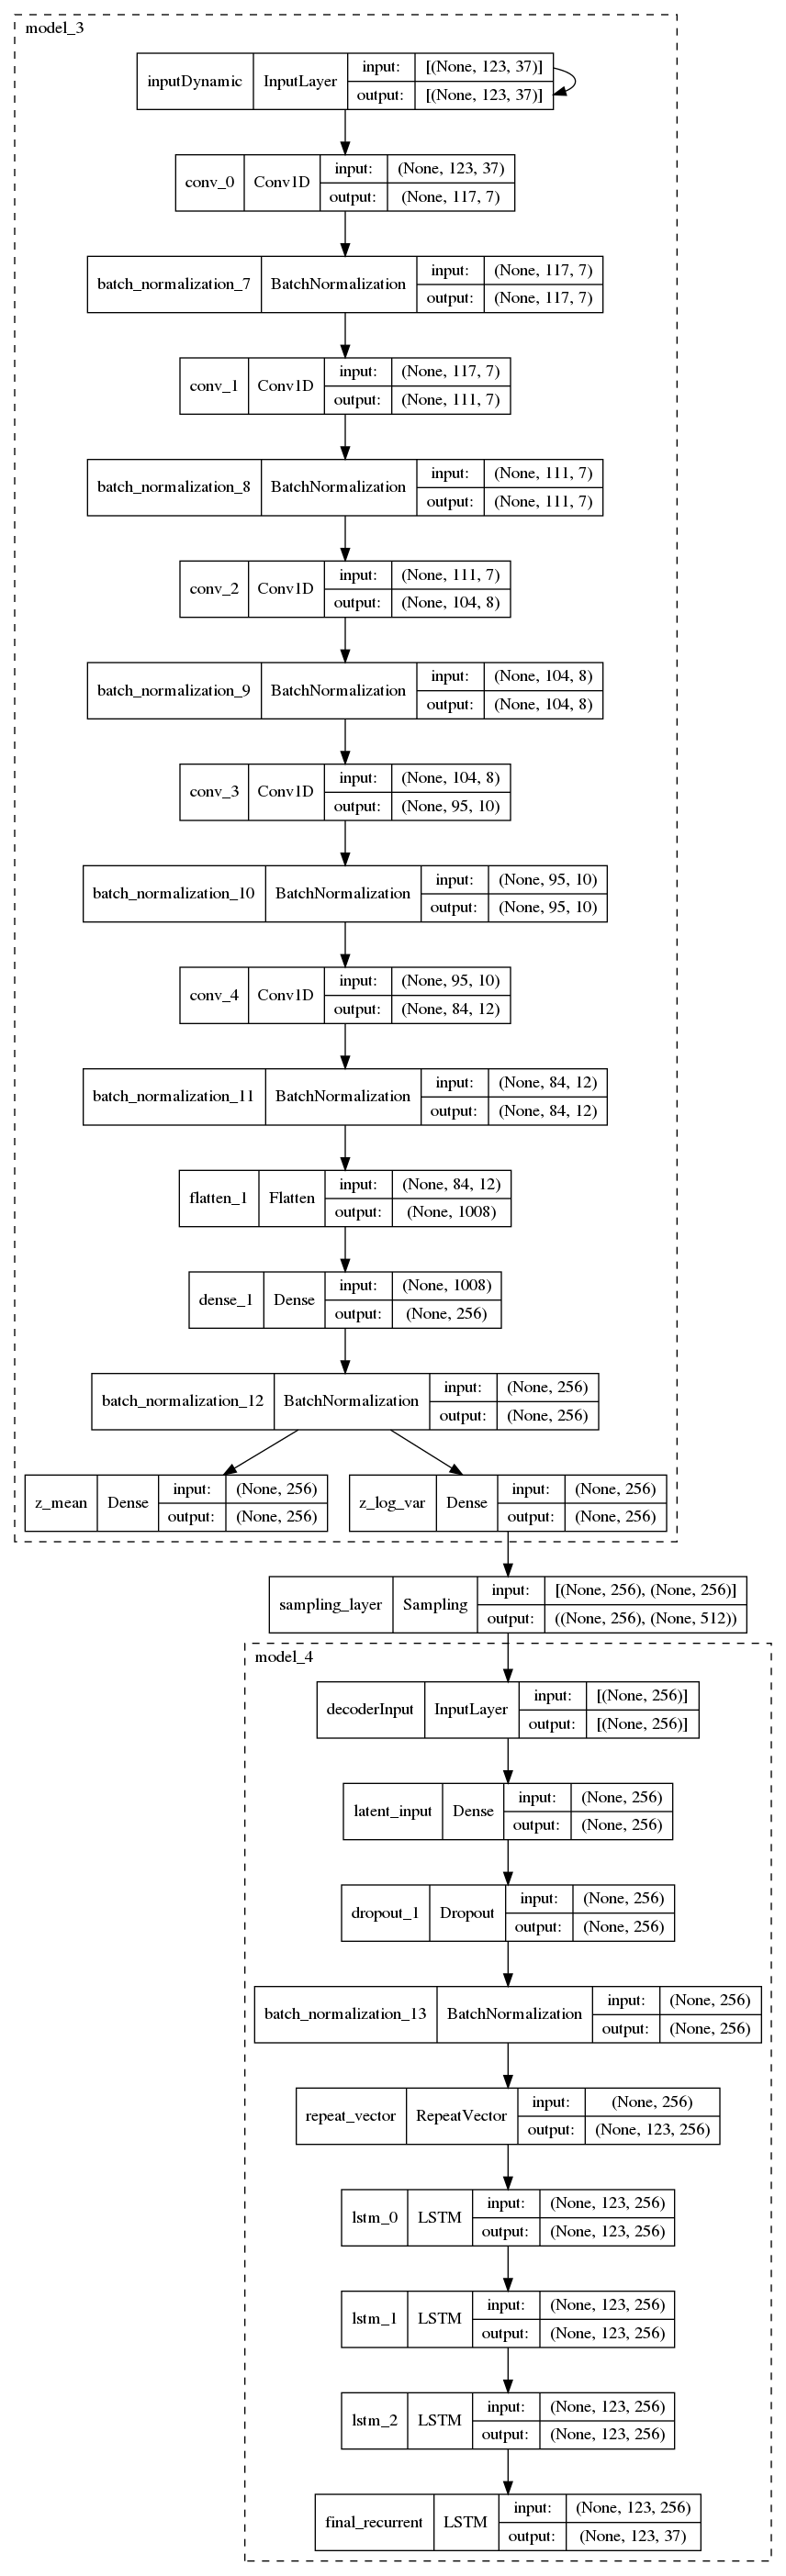

In [15]:
plot_model(autoencoder, expand_nested=True, show_layer_names=True, show_shapes=True)

In [34]:
batch[0].shape

(512, 123, 37)

In [44]:
autoencoder(batch[0])

<tf.Tensor 'model_14/model_13/final_recurrent/transpose_1:0' shape=(128, 123, 37) dtype=float32>

In [29]:
steps_per_epoch

390

In [16]:
tf.compat.v1.experimental.output_all_intermediates(True)
modelFilePath = Path("model_1.model")
checkpoint = ModelCheckpoint(modelFilePath.absolute().as_posix(), save_best_only=True, 
                             save_weights_only=False, monitor='val_loss')
earlyStopping = EarlyStopping(monitor='val_loss', patience=10)

dtime = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
iniLR = 0.01
optimizationEvolution = trainHistory(iniLR, 0.5, 5, dtime)

#callbacks = [earlyStopping, checkpoint, optimizationEvolution]
callbacks = [checkpoint]
autoencoder.fit(cg_train, epochs=5, steps_per_epoch=128) 
#autoencoder.fit(cg_train, epochs=5, validation_data=cg_val, callbacks=callbacks,
#                steps_per_epoch=steps_per_epoch, validation_steps=steps_per_validataion, max_queue_size=10)

Epoch 1/5


TypeError: in user code:

    File "/home/rafalb/miniconda3/envs/tf_chem/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/rafalb/miniconda3/envs/tf_chem/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/rafalb/miniconda3/envs/tf_chem/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/rafalb/miniconda3/envs/tf_chem/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/home/rafalb/miniconda3/envs/tf_chem/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 239, in __call__
        self._loss_metric.update_state(
    File "/home/rafalb/miniconda3/envs/tf_chem/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 73, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/rafalb/miniconda3/envs/tf_chem/lib/python3.8/site-packages/keras/metrics.py", line 177, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/rafalb/miniconda3/envs/tf_chem/lib/python3.8/site-packages/keras/metrics.py", line 451, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "/home/rafalb/miniconda3/envs/tf_chem/lib/python3.8/site-packages/keras/engine/keras_tensor.py", line 255, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_4'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


In [20]:
nCharInSmiles = smilesvec1.dims[0] - 1
nCharSet = smilesvec1.dims[1]
decoderChoice = 1
variational = True

lr = 0.00038
latentDim = 256
convDefinition = {}
convDefinition['initialDimWidth'] = 7
convDefinition['initialDimDepth'] = 7
convDefinition['nCNNlayers'] = 5
convDefinition['expansionCoeff'] = 1.2
encoderDimensions = [convDefinition, latentDim]
decoderDimensions = [latentDim, 256, 256, 256]

hyperParameters = {}
hyperParameters['latentDim'] = latentDim
hyperParameters['convDefinition'] = convDefinition
hyperParameters['encoderDimensions'] = encoderDimensions
hyperParameters['decoderDimensions'] = decoderDimensions
hyperParameters['lr'] = lr

encoder, vae_loss = prepareEncoderCNNDynamic(nCharInSmiles, nCharSet, encoderDimensions, lr, True, batch_size, True)
if decoderChoice == 0:
    decoder = prepareDecoderCNNDynamic(nCharInSmiles, nCharSet, decoderDimensions, lr, True)
elif decoderChoice == 1:
    decoder = prepareDecoderCNN_LSTMDynamic(nCharInSmiles, nCharSet, decoderDimensions, lr, True)


encoderOutput = encoder.get_layer('encoderOutput').output
decoderOutput = decoder(encoderOutput)
autoencoder = Model(inputs=encoder.input, outputs=decoderOutput)

#optimizer = RMSprop(lr=lr)
optimizer = Adam(lr)
if variational:
    lossF = vae_loss
else:
    loddF = 'categorical_crossentropy'

autoencoder.compile(optimizer=optimizer, loss=lossF, metrics=['categorical_crossentropy', 'mean_absolute_error', 'accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputDynamic (InputLayer)      [(None, 123, 37)]    0           []                               
                                                                                                  
 conv_0 (Conv1D)                (None, 117, 7)       1820        ['inputDynamic[0][0]']           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 117, 7)      28          ['conv_0[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 conv_1 (Conv1D)                (None, 111, 7)       350         ['batch_normalization_7[0][

In [ ]:
plot_model(autoencoder, show_shapes=True, expand_nested=True)

In [ ]:
import tensorflow as tf
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:

modelFilePath = Path("model_1.model")
checkpoint = ModelCheckpoint(modelFilePath.absolute().as_posix(), save_best_only=True, 
                             save_weights_only=False, monitor='val_loss')
earlyStopping = EarlyStopping(monitor='val_loss', patience=10)

dtime = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
iniLR = 0.01
optimizationEvolution = trainHistory(iniLR, 0.5, 5, dtime)

callbacks = [earlyStopping, checkpoint, optimizationEvolution]
callbacks = [checkpoint] 
autoencoder.fit(cg_train, epochs=5, validation_data=cg_val, callbacks=callbacks,
                steps_per_epoch=steps_per_epoch, validation_steps=steps_per_validataion, max_queue_size=10)

In [ ]:
sample = cg_val.next()

In [ ]:
smilesvec2.reverse_transform(sample[0][0][:1])

In [ ]:
smilesvec1.reverse_transform(sample[0][0][:1])

In [ ]:
print(smilesvec2.reverse_transform(sample[0][0][:1]))
sample_smiles = smilesvec2.reverse_transform(sample[0][0][:1])
predicted_smiles = autoencoder.predict(sample[0][0][:1])

In [ ]:
np.argmax(predicted_smiles[0][0])

In [ ]:
autoencoder.fit(training_dynamic, training_dynamic, epochs=nEpoch,
                batch_size=nBatch,
                   #callbacks=[early_stopping, checkpoint, optimizationEvolution],
                   callbacks=[early_stopping, checkpoint],
                   validation_data=(testing_dynamic, 
                                    testing_dynamic))